In [1]:
import numpy as np
import os
from pathlib import Path
from keras.preprocessing import image
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [2]:
labels = pd.read_csv("Train/train.csv")

In [3]:
labels_array = np.array(labels.values)
labels_array[2]

array(['298.jpg', 'Pikachu'], dtype=object)

In [5]:
m = labels_array.shape
print(m)
labels_dict = {}
for img_data in labels_array:
    labels_dict[img_data[0]] = img_data[1]

(304, 2)


In [6]:
labels_dict['296.jpg']

'Pikachu'

In [7]:
p = Path("Train/Images")

dirs = p.glob("*")

labels_id = {"Bulbasaur" : 0 ,"Pikachu" : 1, "Charmander" : 2}
image_data = []
labels_data = []

for img_path in dirs:
    labels_name = str(img_path).split("/")[-1]
    img = image.load_img(img_path,target_size=(50,50))
    img_array = image.img_to_array(img)
    image_data.append(img_array)
    lid = labels_dict[labels_name] 
    labels_data.append(labels_id[lid])


/usr/lib/python3/dist-packages/PIL/Image.py:918: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [17]:
X = np.array(image_data)
Y = np.array(labels_data)
X = X/255.0

In [18]:
image_data = np.array(image_data,dtype = 'float32')
labels_data = np.array(labels_data)
print(image_data.shape,labels_data.shape)

(304, 50, 50, 3) (304,)


In [19]:
def drawImg(img):
    plt.imshow(img)
    plt.show()
    return

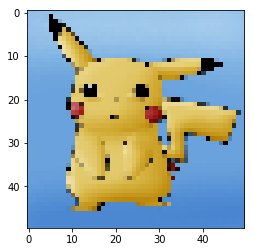

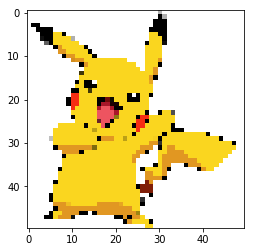

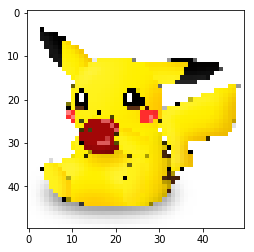

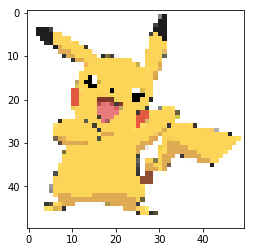

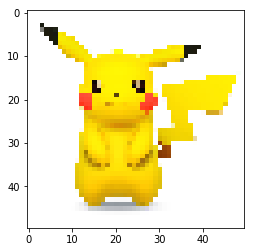

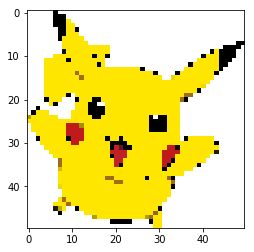

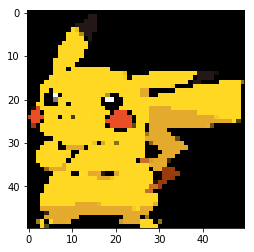

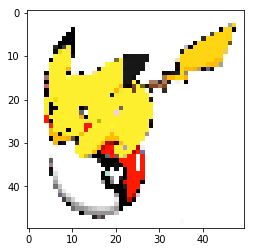

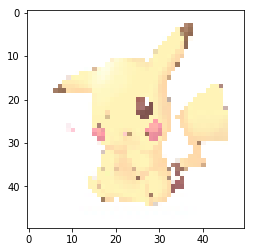

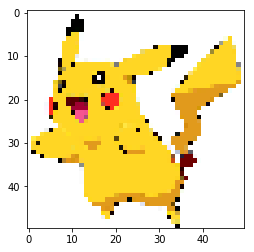

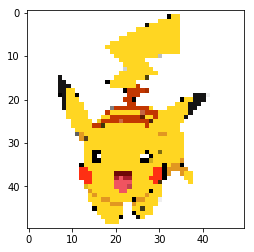

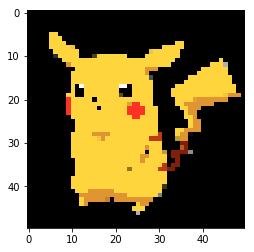

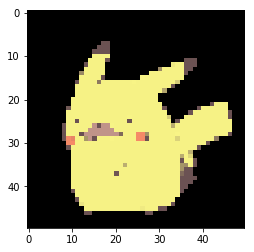

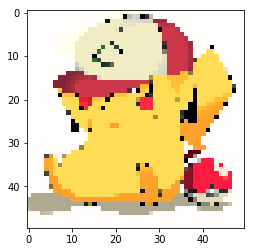

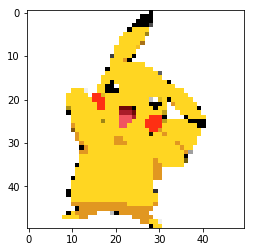

In [20]:
for i in range(15):
    drawImg(X[i])

In [21]:
class SVM:
    "Author : Shubham Shakya"
    def __init__(self,C=1):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeloss(self,W,b,X,Y):
        loss = 0.0
        
        loss+= 0.5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C*max(0,1-ti)
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=100,learning_rate = 0.001,maxItr = 200):
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        #init the model parameter
        W = np.zeros((1,no_of_features))
        bias = 5
        
        #Inital Loss
        #print(self.hingeloss(w,bias,X,Y))
        
        #Training from here...
        #Weight and Bias update rule 
        losses = []
        for i in range(maxItr):
            #Training loop
            
            l = self.hingeloss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #batch gradient Descent with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                gradw = 0
                gradb = 0
                
                #iterate over all examples in the batch 
                for j in range(batch_start,batch_start+batch_size):
                    if(j<no_of_samples):
                        i = ids[j]
                        ti = Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if (ti>1):
                            gradb += 0
                            gradw += 0

                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]

                #gradient for the batch is ready!update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
               
        self.W = W
        self.b = bias
        return W,bias,losses

In [22]:
m = image_data.shape[0]
image_data = image_data.reshape(m,-1)
print(image_data.shape)
print(labels.shape)

(304, 7500)
(304, 2)


In [23]:
classes = len(np.unique(labels_data))
print(classes)

3


In [24]:
def classWiseData(x,y):
    data = {}
    for i in range(classes):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
    
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

In [25]:
main_data = classWiseData(image_data,labels_data)

In [26]:
def getDataPairForSVM(d1,d2):
    "Combines data of two classes into a single matrix"
    
    l1,l2 = d1.shape[0],d2.shape[0]
    
    samples = l1 + l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples,))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = +1

    return data_pair,data_labels

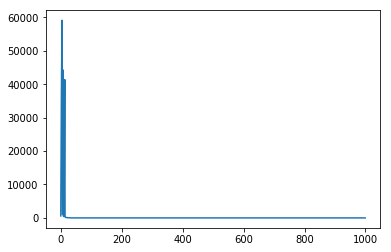

0.010090864213775388


In [27]:
"checking"
mySVM = SVM()
xp,yp = getDataPairForSVM(main_data[0],main_data[1])
w,b,loss =mySVM.fit(xp,yp,learning_rate = 0.0000001,maxItr = 1000)
plt.plot(loss)
plt.show()
print(loss[-2])

In [28]:
def trainSVMs(x,y):
    svm_classifiers = {}
    for i in range(classes):
        svm_classifiers[i] = {}
        for j in range(i+1,classes):
            xpair,ypair = getDataPairForSVM(main_data[i],main_data[j])
            wts,b,loss = mySVM.fit(xpair,ypair,learning_rate=0.0000001,maxItr=1000)
            svm_classifiers[i][j] = (wts,b)
            
            plt.plot(loss)
            plt.show()
            print(loss[-1])
            
    return svm_classifiers

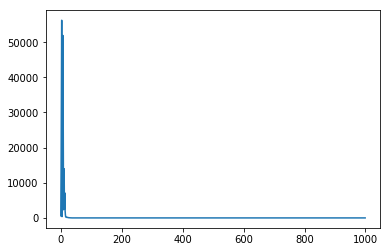

0.01166115191448644


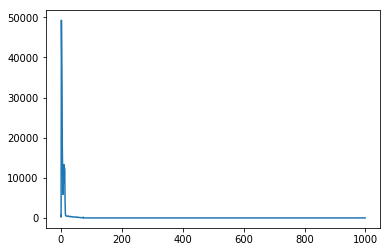

0.010427181656516713


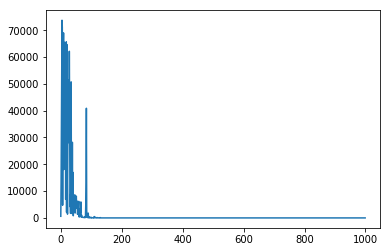

0.05009293537757889


In [29]:
svm_classifiers = trainSVMs(image_data,labels_data)

In [30]:
def binaryPredict(x,w,b):
    z = np.dot(x,w.T) + b
    if (z>=0):
        return 1
    else:
        return -1

In [31]:
def predict(x):
    count = np.zeros((classes,))
    
    rev_labels_id = {0 :"Bulbasaur"  , 1 : "Pikachu" ,2 : "Charmander" }
    for i in range(classes):
        for j in range(i+1,classes):
            w,b = svm_classifiers[i][j]
            #Take a majority prediction 
            z = binaryPredict(x,w,b)
            
            if(z==1):
                count[j] += 1
            else:
                count[i] += 1
    
    final_prediction = np.argmax(count)
    #print(count)
    return rev_labels_id[final_prediction]

In [32]:
predict(image_data[200])

'Bulbasaur'

In [33]:
def accuracy(x,y):
    
    count = 0
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        if(prediction==y[i]):
            count += 1
            
    return count/x.shape[0]

In [34]:
my_img = image.load_img("1106.jpg",target_size=(50,50))
my_img_array = image.img_to_array(my_img)

pokemon = my_img_array.reshape(1,-1)

In [35]:
predict(pokemon)

'Bulbasaur'

## Testing data

In [36]:
Test_labels = pd.read_csv("Test/test.csv")
Test_labels_array = np.array(Test_labels.values)
Test_labels_array[2]

array(['1131.jpg'], dtype=object)

In [39]:
p = Path("Test/Images")

test_dirs = p.glob("*")

test_image_data = {}

for img_path in test_dirs:
    labels_name = str(img_path).split("/")[-1]
    img = image.load_img(img_path,target_size=(50,50))
    img_array = image.img_to_array(img)
    img_array = img_array/255.0
    test_image_data[labels_name] = img_array

In [ ]:
test_

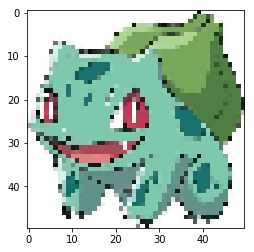

In [40]:
drawImg(test_image_data['1131.jpg'])

In [41]:
result = []

for test_img in test_image_data:
    #print(test_img)
    img = test_image_data[test_img]
    img = img.reshape(1,-1)
    pred = predict(img)
    result.append([test_img,pred])

In [42]:
#result = np.array(zip(ImageId,NameOfPokemon))
print(result)

[['1100.jpg', 'Charmander'], ['1101.jpg', 'Charmander'], ['1102.jpg', 'Charmander'], ['1103.jpg', 'Charmander'], ['1104.jpg', 'Charmander'], ['1105.jpg', 'Charmander'], ['1106.jpg', 'Charmander'], ['1107.jpg', 'Charmander'], ['1108.jpg', 'Charmander'], ['1109.jpg', 'Charmander'], ['1110.jpg', 'Charmander'], ['1111.jpg', 'Charmander'], ['1112.jpg', 'Charmander'], ['1113.jpg', 'Charmander'], ['1114.jpg', 'Charmander'], ['1115.jpg', 'Charmander'], ['1116.jpg', 'Charmander'], ['1117.jpg', 'Charmander'], ['1118.jpg', 'Charmander'], ['1120.jpg', 'Charmander'], ['1121.jpg', 'Charmander'], ['1122.jpg', 'Charmander'], ['1123.jpg', 'Charmander'], ['1124.jpg', 'Charmander'], ['1125.jpg', 'Charmander'], ['1126.jpg', 'Charmander'], ['1127.jpg', 'Charmander'], ['1128.jpg', 'Charmander'], ['1129.jpg', 'Charmander'], ['1130.jpg', 'Charmander'], ['1131.jpg', 'Charmander'], ['1132.jpg', 'Charmander'], ['1133.jpg', 'Charmander'], ['1134.jpg', 'Charmander'], ['1135.jpg', 'Charmander'], ['1136.jpg', 'Charm

In [43]:
pred_result = pd.DataFrame(result,columns = ["ImageId" , "NameOfPokemon"])
pred_result.head(5)

,ImageId,NameOfPokemon
0,1100.jpg,Charmander
1,1101.jpg,Charmander
2,1102.jpg,Charmander
3,1103.jpg,Charmander
4,1104.jpg,Charmander


In [44]:
pred_result.to_csv("Test/pred.csv",index = False)